Imports

In [24]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [25]:
def spectral_flux(y, sr, n_fft=2048, hop_length=512):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S /= (S.max(axis=0, keepdims=True) + 1e-8)
    flux = np.sum(np.maximum(S[:,1:] - S[:,:-1], 0), axis=0)
    times = librosa.frames_to_time(np.arange(1, S.shape[1]), sr=sr, hop_length=hop_length)
    return flux, times

In [26]:
def fourier_tempogram(novelty, sr, hop_length=512, bpm_min=20, bpm_max=250):
    n_frames = len(novelty)
    bpms = np.arange(bpm_min, bpm_max + 1)
    omega = 2 * np.pi * (bpms / 60) * (hop_length / sr)
    T = np.zeros((len(bpms), n_frames))
    t = np.arange(n_frames)
    for i, w in enumerate(omega):
        basis = np.cos(w * t) + 1j * np.sin(w * t)
        norm = np.linalg.norm(basis)
        T[i] = np.real(np.dot(novelty, basis) / norm)
    return T, bpms

In [30]:
def dp_beat_tracker(novelty, sr, hop_length=512, tempo_est=120, lam=10):
    # Convert tempo to expected frame lag
    period_frames = (60.0 / tempo_est) * sr / hop_length
    N = len(novelty)
    D = np.full(N, -np.inf)
    P = np.zeros(N, dtype=int)
    # initialize first beat at frame 0
    D[0] = novelty[0]
    for n in range(1, N):
        # vectorized score: D[m] - lam*((n-m-period_frames)**2)
        m = np.arange(n)
        penalties = lam * ((n - m - period_frames)**2)
        scores = D[m] - penalties
        best_m = np.argmax(scores)
        D[n] = novelty[n] + scores[best_m]
        P[n] = best_m
    print(f"DM = {D[m]}, P = {P[m]}, penalties = {penalties}")
    # backtrack from last frame to get full sequence
    beats = []
    n = N - 1
    while n > 0:
        beats.append(n)
        n = P[n]
    beats.append(0)
    beats = sorted(beats)
    return librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)

In [28]:
def main(audio_path, hop_length=512):
    #Loading and playing the audio file
    y, sr = librosa.load(audio_path, sr=None)
    #sd.play(y, sr); sd.wait()

    #Using the functions made earlier
    novelty, times = spectral_flux(y, sr, hop_length=hop_length)
    T, bpms = fourier_tempogram(novelty, sr, hop_length=hop_length)
    bpm_global = bpms[np.argmax(T.sum(axis=1))]
    print(f"Estimated global tempo: {bpm_global:.1f} BPM")

    beat_times = dp_beat_tracker(novelty, sr, hop_length=hop_length, tempo_est=bpm_global)
    print(f"Detected {len(beat_times)} beats.")
    
    #Adding the clicking noise to each beat found and plays them     
    click = librosa.clicks(times=beat_times, sr=sr, click_freq=660,
                           click_duration=0.1, length=len(y))
    #sd.play(y + click, sr); sd.wait()

    # Plot waveform + beats
    plt.figure(figsize=(10,4))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    for bt in beat_times:
        plt.axvline(bt, color='r', linestyle='--')
    plt.title('Waveform with Detected Beats')
    plt.show()

    # Plot novelty
    plt.figure()
    plt.plot(times, novelty)
    plt.vlines(beat_times, 0, novelty.max(), color='r', linestyle='--')
    plt.title('Novelty with Beats')
    plt.show()
    
    #Plot Mel-Spectrogram
    fig = plt.subplots()
    melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max)
    librosa.display.specshow(melspec, y_axis='mel', x_axis='time')
    
    plt.title('Mel-Spectrogram')
    plt.show()

Estimated global tempo: 94.0 BPM
DM = [    9.24076271 -7000.03958834 -6465.59424745 ...   966.09393514
   975.11029592  1000.45209615], P = [   0    0    0 ... 1261 1262 1264], penalties = [1.59645955e+07 1.59393353e+07 1.59140951e+07 ... 5.99720695e+03
 6.49699086e+03 7.01677477e+03]
Detected 48 beats.


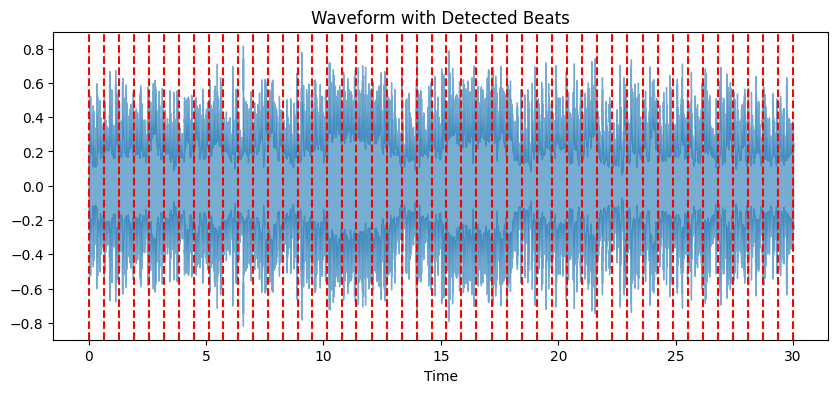

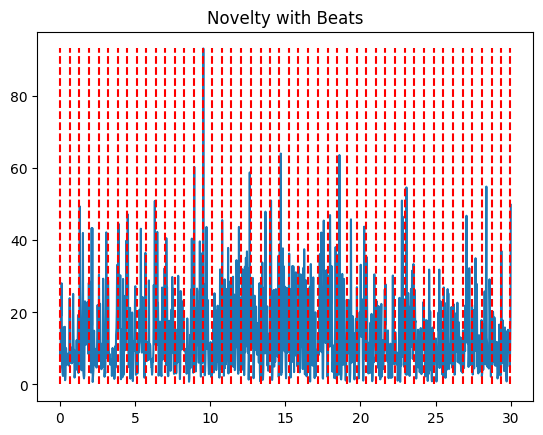

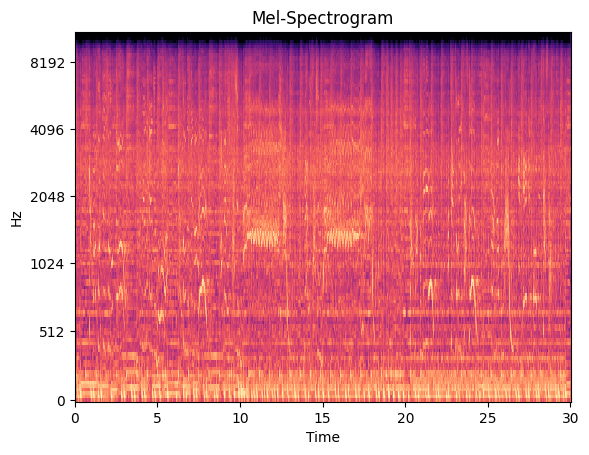

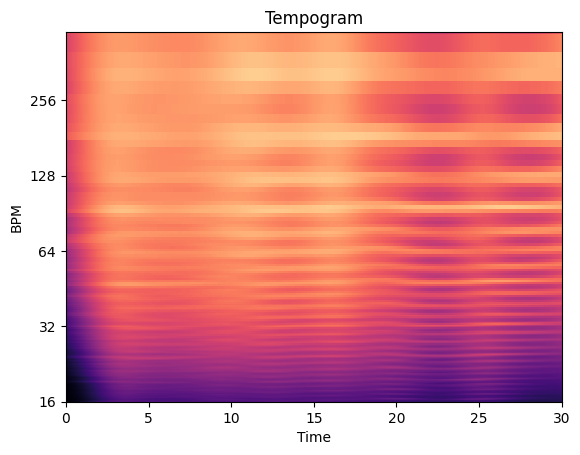

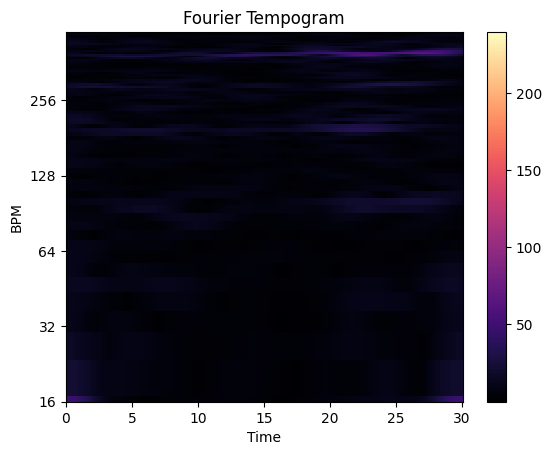

In [31]:
if __name__ == '__main__':
    audio_file = "C:/Users/eriks/PycharmProjects/SoundPro/metal.00003.wav"
    main(audio_file)